# Sensibility

In [1]:
import openseespy.opensees as ops
import openseespy.postprocessing.ops_vis as opsv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time as tm

begin = tm.time()
ops.wipe()
ops.model('basic', '-ndm', 2, '-ndf', 3)

## Unit model kN, m 

In [2]:
def Sensibility(Fy, b, eusmax, R0, cR1, cR2, fpc, e0, Ec, ft, Ets, e20, Ecc, lambdaC, k, ecc0, ecc20):
    #Concrete
    #ops.uniaxialMaterial('Concrete02IS', 11, Ecc, fpc*k, ecc0, 0.2*fpc*k, ecc20, lambdaC, ft, 0.1*Ecc)
    #ops.uniaxialMaterial('Concrete02IS', 12, Ec, fpc, e0, 0.2*fpc, e20, lambdaC, ft, 0.1*Ec)
    ops.uniaxialMaterial('Concrete02', 11, fpc*k, ecc0, 0.2*fpc*k, ecc20, lambdaC, ft, 0.1*Ecc)
    ops.uniaxialMaterial('Concrete02', 12, fpc, e0, 0.2*fpc, e20, lambdaC, ft, 0.1*Ec)
    
    #Steel
    E0 = 200000000
    ops.uniaxialMaterial('Steel02', 2, Fy, E0, b, R0, cR1, cR2)
    ops.uniaxialMaterial('MinMax', 21, 2, '-min', -1e16, '-max', eusmax)
    
    # Define section
    ops.section('Fiber', 1, '-GJ', 1e6)
    W = 4*25.4/1000
    H = 48*25.4/1000
    cover = (0.75-3/8*1.5)*25.4/1000
    nfcover =20
    nfcore = 20
    SB = 2*25.4/1000
    BE = 3*SB
    
    # Concrete Fibers
    # Bottom fibers
    ops.patch('rect', 11, nfcore, 1, -H/2+cover, -W/2+cover, -H/2+BE, W/2-cover)
    ops.patch('rect', 12, nfcover, 1, -H/2, -W/2, -H/2+cover, W/2)

    # Middle fibers
    ops.patch('rect', 11, nfcore, 1, -H/2+BE, -W/2+cover, H/2-BE, W/2-cover)
    ops.patch('rect', 12, nfcover, 1, -H/2+cover, -W/2, H/2-cover, -W/2+cover)  
    ops.patch('rect', 12, nfcover, 1, -H/2+cover, W/2-cover, H/2-cover, W/2)

    # Top fibers
    ops.patch('rect', 11, nfcore, 1, H/2-BE, -W/2+cover, H/2-cover, W/2-cover)
    ops.patch('rect', 12, nfcover, 1, H/2-cover, -W/2, H/2, W/2)
    
    # Steel fibers
    # Bottom Reinforcement 
    AS = 71e-6
    ops.layer('straight', 21, 2, AS, *[-H/2+cover, -W/2+cover], *[-H/2+cover, W/2-cover])
    ops.layer('straight', 21, 2, AS, *[-H/2+BE-cover-SB, -W/2+cover], *[-H/2+cover+SB, -W/2+cover])
    ops.layer('straight', 21, 2, AS, *[-H/2+BE-cover-SB, W/2-cover], *[-H/2+cover+SB, W/2-cover])
    ops.layer('straight', 21, 2, AS, *[-H/2+BE-cover, -W/2+cover], *[-H/2+BE-cover, W/2-cover])

    #Top Reinforcement 
    AS3 = 71e-6
    ops.layer('straight', 21, 2, AS3, *[H/2+cover-BE+cover, -W/2+cover], *[H/2+cover-BE+cover, W/2-cover])
    ops.layer('straight', 21, 2, AS3, *[H/2-BE+cover+SB, -W/2+cover], *[H/2-cover-SB, -W/2+cover])
    ops.layer('straight', 21, 2, AS3, *[H/2-BE+cover+SB, W/2-cover], *[H/2-cover-SB, W/2-cover])
    ops.layer('straight', 21, 2, AS3, *[H/2-cover, -W/2+cover], *[H/2-cover, W/2-cover])

    # Middle reinforcement
    AS2 = 32e-6
    ops.layer('straight', 21, 4, AS2, *[-H/2+BE+7.5*25.4/1000, W/2-cover], *[H/2-BE-7.5*25.4/1000, W/2-cover])
    ops.layer('straight', 21, 4, AS2, *[-H/2+BE+7.5*25.4/1000, -W/2+cover], *[H/2-BE-7.5*25.4/1000, -W/2+cover])
    
    # Nodes
    HF = 36*25.4/1000
    ops.node(1, 0.0, 0.0)
    ops.node(2, 0.0, HF)
    ops.node(3, 0.0, 2*HF)
    ops.node(4, 0.0, 3*HF)
    ops.node(5, 0.0, 4*HF)
    ops.fix(1, 1, 1, 1)

    #Elements
    ops.geomTransf('Linear', 1)
    ops.beamIntegration('Lobatto', 1, 1, 3)
    ops.element('forceBeamColumn', 1, 1, 2, 1, 1)
    ops.element('forceBeamColumn', 2, 2, 3, 1, 1)
    ops.element('forceBeamColumn', 3, 3, 4, 1, 1)
    ops.element('forceBeamColumn', 4, 4, 5, 1, 1)
    
    #Loads
    
    #Gravity
    Pcol = 0.1*fpc*W*H
    ops.timeSeries('Linear', 1)
    ops.pattern('Plain', 1, 1)
    ops.load(5, 0.0, Pcol, 0.0)
    ops.constraints('Plain')
    ops.numberer('Plain')
    ops.system('BandGeneral')
    ops.test('EnergyIncr', 1e-5, 300)
    ops.algorithm('Newton')
    NSteps = 20
    ops.integrator('LoadControl', 1/NSteps)
    ops.analysis('Static')
    ok = ops.analyze(NSteps)
    ops.wipeAnalysis()
    ops.loadConst('-time', 0.0)
    
    # Cyclic
    ops.timeSeries('Linear', 2)
    ops.pattern('Plain', 2, 2)
    ops.load(5, 1.0 , 0.0, 0.0)
    Peaks = np.loadtxt('Disp.txt')
    ops.recorder('Node', '-file', '72.txt', '-time', '-node', 5, '-dof', 1, 'disp')
    DispControl(5, 1, Peaks)
    ops.wipeAnalysis()
    ops.remove('recorders')

In [3]:
def DispControl(node, DOF, Peaks):
    dp = np.diff(Peaks)
    ops.constraints('Plain')
    ops.numberer('Plain')
    ops.system('BandGeneral') 
    # The algorithm Newton Raphson need a slope to solve the problem,'-initial' indicates to use the inicial slope
    ops.algorithm('Newton', '-initial')
    ops.test('NormDispIncr', 1e-5, 300)
    ops.analysis('Static')
        
    for i in range(len(dp)):
        for n in [1]:
            ops.integrator('DisplacementControl', node, DOF, dp[i])
            ok = ops.analyze(n)
            if ok != 0:
                print('Analysis Failed')
            if ok == 0:
                break

    return ok
    
    ops.wipeAnalysis()
    ops.remove('recorders')

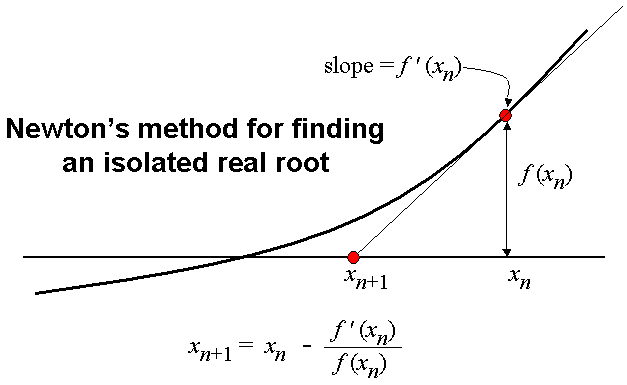

In [4]:
Sensibility(Fy=414000, b=0.007, eusmax=0.135, R0=15, cR1=0.93, cR2=0.15, fpc=-27.6e3, e0=-0.002, Ec=27600000, 
            ft=3280, Ets=0.1*27600000, e20=-0.006, Ecc=5980000, lambdaC=0.6, k=1.5, ecc0=-0.012, ecc20=-0.0275)

WARNING analysis Static - no Integrator specified, 
 StaticIntegrator default will be used


In [5]:
# Sensibility
Test = np.loadtxt('Sensibility_Output.txt')
Push = np.loadtxt('72.txt')
#plt.plot(Test[:,3],Test[:,2])
Error_force = np.zeros(len(Push[:, 0]))
Error_disp = np.zeros(len(Push[:, 0]))
Error_total = 0

for i in range(len(Push[:, 0])):
    Error_force[i] = Test[i, 2] - Push[i, 0]
    Error_disp[i] = Test[i, 3] - Push[i, 1]
    Error_total = Error_total + Error_force[i]**2 + Error_disp[i]**2
    Error_total = np.sqrt(Error_total)
    
print('Total Error: {:.2f}'.format(Error_total))
end = tm.time()
exc_time = end - begin
print('Execution time: {:.2f} s'.format(exc_time))

Total Error: 2.50
Execution time: 1.88 s


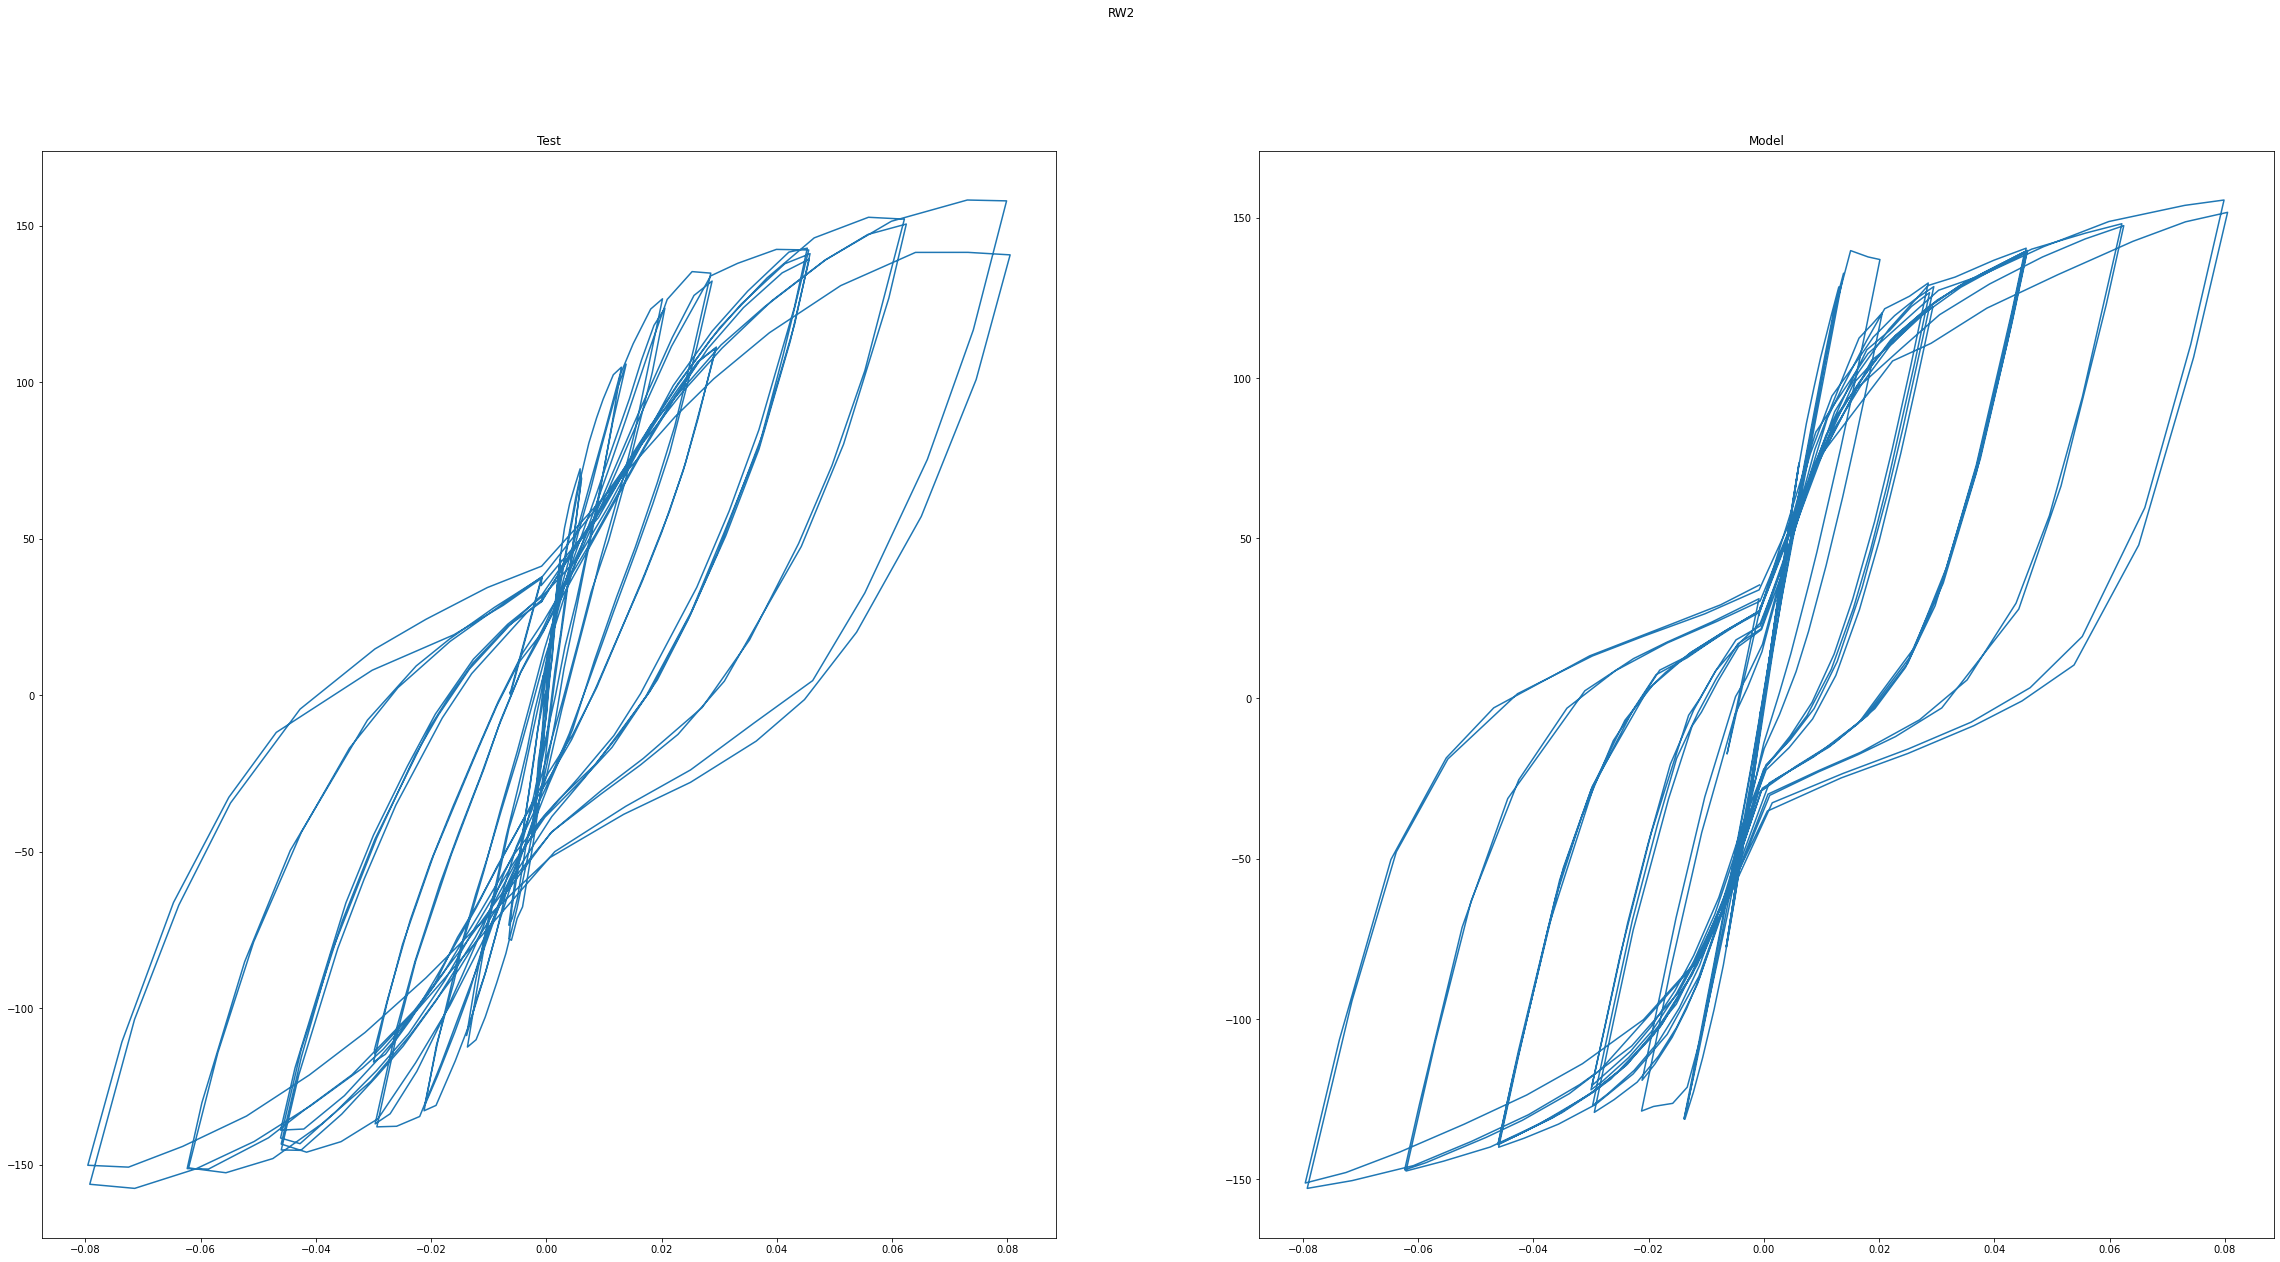

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('RW2')
ax1.plot(Test[:,3],Test[:,2])
ax2.plot(Push[:,1], Push[:,0])
ax1.set_title('Test')
ax2.set_title('Model')
#plt.rcParams["figure.figsize"] = (40,20)